In [3]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import regex as re

from scripts.importing import import_data

from scripts.cleaning import group

ModuleNotFoundError: No module named 'regex'

In [140]:
df = import_data(file='db_cut.parquet')
df = df.drop(columns='index')
df['name_release'] = df['release_adjusted'].str[-2:]
df.head()

importing data...
end


,brand,release_adjusted,area_dedalo,launch_type,sku,year_week,brand_category,model,lens_width,division,...,distribution_segment,fitting,lens_height,bridge_size,temple_length,fsd,material,size,order_quantity,name_release
0,A0,2023 N1,BRASIL,BRA,0A0309954012,202305,LUXURY BRANDS,0A03099,54,OPTICAL,...,HM,International,39.8,18.0,145.0,2023-03-24,ACETATE,S,2,N1
1,A0,2023 N1,BRASIL,BRA,0A0309954012,202309,LUXURY BRANDS,0A03099,54,OPTICAL,...,HM,International,39.8,18.0,145.0,2023-03-24,ACETATE,S,1,N1
2,A0,2023 N1,BRASIL,BRA,0A0309954012,202313,LUXURY BRANDS,0A03099,54,OPTICAL,...,HM,International,39.8,18.0,145.0,2023-03-24,ACETATE,S,1,N1
3,A0,2023 N1,BRASIL,BRA,0A0309954013,202305,LUXURY BRANDS,0A03099,54,OPTICAL,...,HM,International,39.8,18.0,145.0,2023-03-24,ACETATE,S,2,N1
4,A0,2023 N1,BRASIL,BRA,0A0309954013,202329,LUXURY BRANDS,0A03099,54,OPTICAL,...,HM,International,39.8,18.0,145.0,2023-03-24,ACETATE,S,1,N1


In [141]:
df_grouped = df.groupby(by = ['brand','launch_type', 'area_dedalo', 'name_release', 'year_week'], as_index=False)['order_quantity'].sum()
df_grouped = df_grouped.sort_values(['brand','launch_type', 'area_dedalo', 'name_release', 'year_week'])




In [142]:
df_grouped

,brand,launch_type,area_dedalo,name_release,year_week,order_quantity
0,6A,FIL,MUESED,N1,202210,2
1,6A,FIL,MUESED,N1,202214,1
2,6A,FIL,MUESED,N2,202313,7
3,6A,USA,NACOMM,N1,202316,198
4,6A,USA,NACOMM,N1,202321,1
...,...,...,...,...,...,...
182158,XD,USA,NORAME,N2,202309,1
182159,XD,USA,NORAME,N2,202311,2
182160,XD,USA,NORAME,N2,202312,2
182161,XD,USA,NORAME,N2,202313,5


In [143]:
# creiamo range date
min_yw, max_yw = df_grouped.year_week.min(),  df_grouped.year_week.max()

def yearweek_to_datetime(yearweek_str):
    yearweek_str = str(yearweek_str)
    year = yearweek_str[:4]
    week = yearweek_str[4:]
    # Parse the year and week and combine it with '0' for Sunday
    datetime_str = f'{year} {week} 0'
    # Convert to datetime object, %U is week number of the year, Sunday as the first day of week, 00-53
    # %w is the day of the week, with Sunday as 0
    return pd.to_datetime(datetime_str, format='%Y %U %w')

min_yw, max_yw = yearweek_to_datetime(min_yw),  yearweek_to_datetime(max_yw)
df_dates = pd.DataFrame({'year_week': pd.date_range(start=min_yw, end=max_yw, freq='W-SUN').strftime("%Y%W")})
df_base = df_grouped[['brand','launch_type', 'area_dedalo','name_release']].drop_duplicates().reset_index(drop=True)

df_merge = df_base.merge(df_dates, how='cross')
df_merge['year_week'] = df_merge['year_week'].astype(int)

df_grouped_shift = df_merge.merge(df_grouped, how='left').fillna(0)

df_grouped_shift

,brand,launch_type,area_dedalo,name_release,year_week,order_quantity
0,6A,FIL,MUESED,N1,201445,0.0
1,6A,FIL,MUESED,N1,201446,0.0
2,6A,FIL,MUESED,N1,201447,0.0
3,6A,FIL,MUESED,N1,201448,0.0
4,6A,FIL,MUESED,N1,201449,0.0
...,...,...,...,...,...,...
597613,XD,USA,NORAME,N2,202330,0.0
597614,XD,USA,NORAME,N2,202331,0.0
597615,XD,USA,NORAME,N2,202332,0.0
597616,XD,USA,NORAME,N2,202333,0.0


In [144]:
for shift in range(1,6):
    if shift < 5:
        df_grouped_shift[f'order_quantity_{shift}'] = df_grouped_shift.groupby(by = ['brand','launch_type', 'area_dedalo', 'name_release'], as_index=False)['order_quantity'].shift(shift)
    else:
        df_grouped_shift[f'order_quantity_{52}'] = df_grouped_shift.groupby(by = ['brand','launch_type', 'area_dedalo', 'name_release'], as_index=False)['order_quantity'].shift(52)

    
df_grouped_shift = df_grouped_shift.dropna(axis=0)

[Text(0.5, 0, 'order_quantity'),
 Text(1.5, 0, 'order_quantity_1'),
 Text(2.5, 0, 'order_quantity_2'),
 Text(3.5, 0, 'order_quantity_3'),
 Text(4.5, 0, 'order_quantity_4'),
 Text(5.5, 0, 'order_quantity_52')]

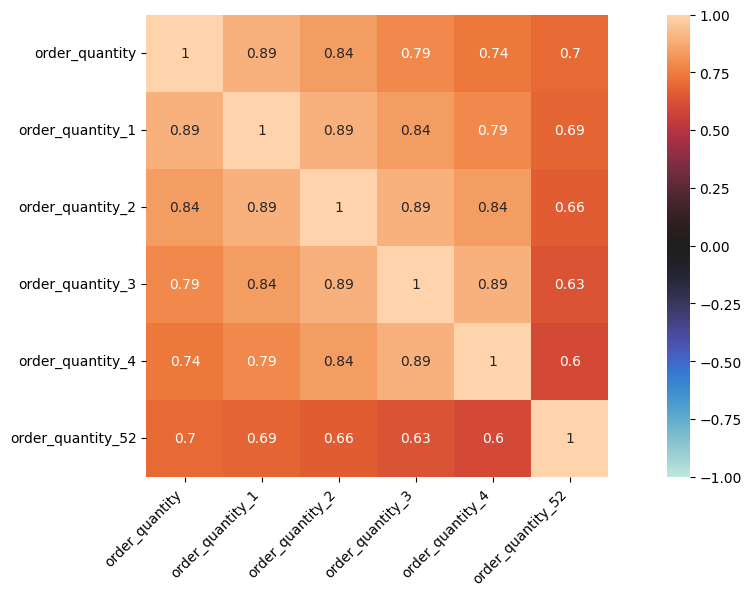

In [145]:
corr = df_grouped_shift[['order_quantity'] +[f'order_quantity_{shift}'for shift in range (1,5)] + [f'order_quantity_{52}'] ].corr()
plt.figure(figsize=(15, 6))
ax = sns.heatmap(corr, vmin=-1, vmax=1, square=True, cmap='icefire', annot=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
# it seems there are not highly correlated variables

In [146]:
df_grouped_shift

,brand,launch_type,area_dedalo,name_release,year_week,order_quantity,order_quantity_1,order_quantity_2,order_quantity_3,order_quantity_4,order_quantity_52
52,6A,FIL,MUESED,N1,201545,0.0,0.0,0.0,0.0,0.0,0.0
53,6A,FIL,MUESED,N1,201546,0.0,0.0,0.0,0.0,0.0,0.0
54,6A,FIL,MUESED,N1,201547,0.0,0.0,0.0,0.0,0.0,0.0
55,6A,FIL,MUESED,N1,201548,0.0,0.0,0.0,0.0,0.0,0.0
56,6A,FIL,MUESED,N1,201549,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
597613,XD,USA,NORAME,N2,202330,0.0,0.0,0.0,0.0,0.0,2.0
597614,XD,USA,NORAME,N2,202331,0.0,0.0,0.0,0.0,0.0,0.0
597615,XD,USA,NORAME,N2,202332,0.0,0.0,0.0,0.0,0.0,0.0
597616,XD,USA,NORAME,N2,202333,0.0,0.0,0.0,0.0,0.0,1.0


In [147]:
def camel_to_snake(name):
    """
    Convert camelCase, PascalCase, or mixed case with underscores to snake_case.
    Args:
    name (str): The string to convert.
    Returns:
    str: The converted string in snake_case.
    """
    # Replace dots with underscores
    step0 = name.replace('.', '_')
    # Insert an underscore before any uppercase letter followed by a lowercase letter, e.g., 'YearMonth' -> 'Year_Month'
    step1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', step0)
    # Next, insert an underscore between lowercase letters/numbers and uppercase letters, e.g., 'Made_In' -> 'Made_In', 'Year_Month' -> 'Year_Month'
    step2 = re.sub('([a-z0-9])([A-Z])', r'\1_\2', step1)
    # Finally, convert to lowercase and replace multiple consecutive underscores with a single one
    return re.sub('_+', '_', step2).lower().replace(' ', '')

# Custom function to get a single mode
def get_single_mode(series):
    modes = series.mode()
    if not modes.empty:
        return modes.iloc[0]
    else:
        # Handle the case of multiple modes (return the first mode)
        return np.nan



# performing one-hot encoding on categorical variables
df_pre_encoded = df.drop(columns=['year_week','order_quantity', 'area_dedalo', 'fsd'] ).drop_duplicates()
df_encoded = pd.get_dummies(df_pre_encoded, columns=['brand_category', 'division', 'variant', 'madein_area', 'shape', 'front_colour', 'lifecycle_type', 'management_mode', 'distribution_segment', 'fitting', 'material', 'size'])
df_encoded.columns = [camel_to_snake(name) for name in df_encoded.columns]
df_encoded.columns = df_encoded.columns.str.replace(r'/', '_')

agg_dict = {'sku':'nunique', 'model':'nunique', 'advertising':'sum', 'madein_area_br':'sum', 'madein_area_cn':'sum',
'madein_area_in':'sum', 'madein_area_it':'sum', 'madein_area_jp':'sum', 'madein_area_th':'sum', 'madein_area_us':'sum',
'shape_butterfly':'sum', 'shape_cateye':'sum', 'shape_irregular':'sum', 'shape_oval':'sum', 'shape_phantos':'sum', 'shape_pillow':'sum', 'shape_pilot':'sum',
'shape_rectangle':'sum', 'shape_round':'sum', 'shape_square':'sum', 'front_colour_black':'sum', 'front_colour_blue':'sum', 'front_colour_bordeaux':'sum',
'front_colour_bronze_copper':'sum', 'front_colour_brown':'sum', 'front_colour_camo':'sum', 'front_colour_clear':'sum', 'front_colour_gold':'sum',
'front_colour_green':'sum', 'front_colour_grey':'sum', 'front_colour_gunmetal':'sum', 'front_colour_havana':'sum', 'front_colour_honey':'sum',
'front_colour_ivory':'sum', 'front_colour_lightblue':'sum', 'front_colour_lightbrown':'sum', 'front_colour_multi':'sum', 'front_colour_notapplicable':'sum',
'front_colour_orange':'sum', 'front_colour_pink':'sum', 'front_colour_purple_reddish':'sum', 'front_colour_red':'sum', 'front_colour_silver':'sum',
'front_colour_violet':'sum', 'front_colour_white':'sum', 'front_colour_yellow':'sum', 'lifecycle_type_ce':'sum', 'lifecycle_type_co':'sum',
'lifecycle_type_ld':'sum', 'lifecycle_type_nd':'sum', 'lifecycle_type_ou':'sum', 'lifecycle_type_pe':'sum', 'lifecycle_type_re':'sum', 'lifecycle_type_se':'sum', 'management_mode_exc':'sum', 'management_mode_reg':'sum', 'management_mode_spe':'sum', 
'fitting_asian_design':'sum', 'fitting_asian_fitting':'sum',
'fitting_full_fitting':'sum', 'fitting_international':'sum', 'material_acetate':'sum', 'material_injected':'sum', 'material_metal':'sum',
'material_notdefined':'sum', 'material_steel':'sum', 'material_titanium':'sum', 'material_wood':'sum', 'size_xxs':'sum', 'size_xs':'sum', 'size_s':'sum',
'size_m':'sum', 'size_l':'sum', 'size_xl':'sum','size_xxl':'sum'
}



df_grouped_encoded = df_encoded.groupby(['brand','launch_type',  'name_release', 'release_adjusted'], as_index=False).agg(agg_dict)
lst_check = np.array([])

#check
for name in ['madein', 'shape', 'front','lifecycle','fitting','management', 'material', 'size']:
    print(name)
    df_temp = df_grouped_encoded[[cols for cols in df_grouped_encoded.columns if cols.startswith(name)]+ ['brand', 'sku']]
    df_temp['check'] = df_temp[[cols for cols in df_grouped_encoded.columns if cols.startswith(name)]].sum(axis=1)

    lst_check = np.append( lst_check, (df_temp['check'] == df_temp['sku']).values)
print(pd.DataFrame({'check': lst_check}).all())

madein
shape
front
lifecycle
fitting
management
material
size
check    True
dtype: bool


/var/folders/4n/7zm_f9b959gbsyh_5ld2nw_80000gn/T/ipykernel_2204/2221302885.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['check'] = df_temp[[cols for cols in df_grouped_encoded.columns if cols.startswith(name)]].sum(axis=1)
/var/folders/4n/7zm_f9b959gbsyh_5ld2nw_80000gn/T/ipykernel_2204/2221302885.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['check'] = df_temp[[cols for cols in df_grouped_encoded.columns if cols.startswith(name)]].sum(axis=1)
/var/folders/4n/7zm_f9b959gbsyh_5l

In [148]:
df_grouped_encoded

,brand,launch_type,name_release,release_adjusted,sku,model,advertising,madein_area_br,madein_area_cn,madein_area_in,...,material_steel,material_titanium,material_wood,size_xxs,size_xs,size_s,size_m,size_l,size_xl,size_xxl
0,6A,FIL,N1,2022 N1,3,2,0,0,3,0,...,0,0,0,0,1,0,2,0,0,0
1,6A,FIL,N2,2022 N2,7,5,0,0,5,0,...,0,0,0,3,3,0,1,0,0,0
2,6A,USA,N1,2022 N1,24,10,0,0,24,0,...,0,0,0,2,6,6,10,0,0,0
3,6A,USA,N1,2023 N1,50,15,0,0,50,0,...,0,0,0,6,14,18,9,3,0,0
4,6A,USA,N2,2021 N2,21,8,0,0,21,0,...,0,0,0,0,3,13,5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2814,XD,FIL,N1,2023 N1,6,3,0,0,6,0,...,0,0,0,0,0,0,4,2,0,0
2815,XD,USA,N1,2021 N1,7,3,0,0,7,0,...,0,0,0,0,0,0,0,0,2,5
2816,XD,USA,N1,2022 N1,22,4,0,0,22,0,...,0,0,0,0,0,0,5,11,0,6
2817,XD,USA,N1,2023 N1,20,3,0,0,20,0,...,0,0,0,0,0,0,11,9,0,0


In [153]:
df_grouped_shift[(df_grouped_shift.brand == 'RB')]

,brand,launch_type,area_dedalo,name_release,year_week,order_quantity,order_quantity_1,order_quantity_2,order_quantity_3,order_quantity_4,order_quantity_52
409939,RB,BRA,BRASIL,N1,201545,4326.0,6399.0,6390.0,5227.0,3739.0,0.0
409940,RB,BRA,BRASIL,N1,201546,12094.0,4326.0,6399.0,6390.0,5227.0,0.0
409941,RB,BRA,BRASIL,N1,201547,12435.0,12094.0,4326.0,6399.0,6390.0,0.0
409942,RB,BRA,BRASIL,N1,201548,824.0,12435.0,12094.0,4326.0,6399.0,0.0
409943,RB,BRA,BRASIL,N1,201549,751.0,824.0,12435.0,12094.0,4326.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
426406,RB,USA,NORAME,N2,202330,0.0,0.0,0.0,0.0,0.0,254.0
426407,RB,USA,NORAME,N2,202331,0.0,0.0,0.0,0.0,0.0,8.0
426408,RB,USA,NORAME,N2,202332,0.0,0.0,0.0,0.0,0.0,2221.0
426409,RB,USA,NORAME,N2,202333,0.0,0.0,0.0,0.0,0.0,3030.0


In [156]:
df_rel_date = df[['release_adjusted','name_release','year_week']].drop_duplicates()

In [157]:
df_rel_date

,release_adjusted,name_release,year_week
0,2023 N1,N1,202305
1,2023 N1,N1,202309
2,2023 N1,N1,202313
4,2023 N1,N1,202329
5,2023 N1,N1,202330
...,...,...,...
6931931,2017 N1,N1,201522
6931932,2017 N1,N1,201525
6931945,2017 N1,N1,201524
6931952,2017 N1,N1,201510


In [159]:
df_grouped_encoded_date = df_grouped_encoded.merge(df_rel_date)

In [168]:
df_ready = df_grouped_shift.merge(df_grouped_encoded_date, how='left').fillna(method='ffill').dropna()

In [169]:
df_ready

,brand,launch_type,area_dedalo,name_release,year_week,order_quantity,order_quantity_1,order_quantity_2,order_quantity_3,order_quantity_4,...,material_steel,material_titanium,material_wood,size_xxs,size_xs,size_s,size_m,size_l,size_xl,size_xxl
49,6A,FIL,MUESED,N1,201642,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
50,6A,FIL,MUESED,N1,201643,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
51,6A,FIL,MUESED,N1,201644,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
52,6A,FIL,MUESED,N1,201645,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
53,6A,FIL,MUESED,N1,201646,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958197,XD,USA,NORAME,N2,202330,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
958198,XD,USA,NORAME,N2,202331,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
958199,XD,USA,NORAME,N2,202332,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
958200,XD,USA,NORAME,N2,202333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [175]:
import pyarrow

df_ready.to_parquet('df_ready.parquet', engine='pyarrow')

In [4]:
df_prova = pd.read_parquet('df_ready.parquet', engine='pyarrow')

In [5]:
df_prova

,brand,launch_type,area_dedalo,name_release,year_week,order_quantity,order_quantity_1,order_quantity_2,order_quantity_3,order_quantity_4,...,material_steel,material_titanium,material_wood,size_xxs,size_xs,size_s,size_m,size_l,size_xl,size_xxl
49,6A,FIL,MUESED,N1,201642,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
50,6A,FIL,MUESED,N1,201643,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
51,6A,FIL,MUESED,N1,201644,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
52,6A,FIL,MUESED,N1,201645,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
53,6A,FIL,MUESED,N1,201646,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958197,XD,USA,NORAME,N2,202330,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
958198,XD,USA,NORAME,N2,202331,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
958199,XD,USA,NORAME,N2,202332,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
958200,XD,USA,NORAME,N2,202333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
